## H2O AutoML Binary Classification Demo



**Start H2O**
Import the h2o Python module and 
`H2OAutoML class and initialize a local H2O cluster.`

In [1]:
!pip install h2o

     |████████████████████████████████| 176.0 MB 6.3 kB/s 
  Created wheel for h2o: filename=h2o-3.36.0.2-py2.py3-none-any.whl size=176112127 sha256=5ce30cc90d469a1fa32411f39493635c0a746d82a5cd6f07cf8c68b8c5e7a144
  Stored in directory: /root/.cache/pip/wheels/0b/83/bd/343a6140119b4098103e725e1cfe9f198568d13cf103acbc7c
Successfully built h2o


In [2]:
import h2o
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpv8710o8z
  JVM stdout: /tmp/tmpv8710o8z/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpv8710o8z/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.0.2
H2O_cluster_version_age:,19 days
H2O_cluster_name:,H2O_from_python_unknownUser_z6px2k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


**Load Data**
For the AutoML binary classification demo, we use a subset of the `Product Backorders dataset`. The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [3]:
# Use local data file or download from GitHub
from h2o.automl import H2OAutoML
churn_df = h2o.import_file('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
churn_df.types 

{'Churn': 'enum',
 'Contract': 'enum',
 'Dependents': 'enum',
 'DeviceProtection': 'enum',
 'InternetService': 'enum',
 'MonthlyCharges': 'real',
 'MultipleLines': 'enum',
 'OnlineBackup': 'enum',
 'OnlineSecurity': 'enum',
 'PaperlessBilling': 'enum',
 'Partner': 'enum',
 'PaymentMethod': 'enum',
 'PhoneService': 'enum',
 'SeniorCitizen': 'int',
 'StreamingMovies': 'enum',
 'StreamingTV': 'enum',
 'TechSupport': 'enum',
 'TotalCharges': 'real',
 'customerID': 'string',
 'gender': 'enum',
 'tenure': 'int'}

We will notice that the response column, **"went_on_backorder"**, is already encoded as `"enum"`, so there's nothing we need to do here. If it were encoded as a 0/1 `"int"`, then we'd have to convert the column as follows: `df[y] = df[y].asfactor()`

Next, let's identify the response & predictor columns by saving them as x and y. The "sku" column is a unique identifier so we'll want to remove that from the set of our predictors.

In [5]:
churn_df.describe()

Rows:7043
Cols:21




,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
type,string,enum,int,enum,enum,int,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,enum,real,real,enum
mins,NaN,,0.0,,,0.0,,,,,,,,,,,,,18.25,18.8,
mean,NaN,,0.1621468124378816,,,32.37114865824223,,,,,,,,,,,,,64.76169246059916,2283.300440841865,
maxs,NaN,,1.0,,,72.0,,,,,,,,,,,,,118.75,8684.8,
sigma,NaN,,0.3686116056100131,,,24.559481023094456,,,,,,,,,,,,,30.090047097678482,2266.771361883145,
zeros,0,,5901,,,11,,,,,,,,,,,,,0,0,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0
0,7590-VHVEG,Female,0.0,Yes,No,1.0,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0.0,No,No,34.0,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0.0,No,No,2.0,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [6]:
churn_train,churn_test,churn_valid = churn_df.split_frame(ratios=[.7, .15])

In [7]:
churn_train

customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.1,1949.4,No
7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.8,3046.05,Yes
6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No
9763-GRSKD,Male,0,Yes,Yes,13,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Mailed check,49.95,587.45,No
7469-LKBCI,Male,0,No,No,16,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),18.95,326.8,No
8091-TTVAX,Male,0,Yes,No,58,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,One year,No,Credit card (automatic),100.35,5681.1,No
0280-XJGEX,Male,0,No,No,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.7,5036.3,Yes


In [8]:
y = "Churn"
x = churn_df.columns
x.remove(y)
x.remove("customerID")

In [11]:
aml = H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble"])

## Run AutoML
Run AutoML, stopping after 10 models. The `max_models` argument specifies the number of individual (or "base") models, and does not include the two ensemble models that are trained at the end.

In [12]:
aml.train(x = x, y = y, training_frame = churn_train, validation_frame=churn_valid)

AutoML progress: |
06:00:34.440: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

███████████████████████████████████████████████████████████████| (done) 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_1_20220214_60034


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,41.0,41.0,17554.0,7.0,11.0,8.560976,27.0,32.0,29.341463




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11909520561274177
RMSE: 0.3451017322656346
LogLoss: 0.37127435448913787
Mean Per-Class Error: 0.19708017609620396
AUC: 0.8839965515657546
AUCPR: 0.7283216221605053
Gini: 0.7679931031315093

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3134159128651426: 


,,No,Yes,Error,Rate
0,No,2909.0,728.0,0.2002,(728.0/3637.0)
1,Yes,252.0,1047.0,0.194,(252.0/1299.0)
2,Total,3161.0,1775.0,0.1985,(980.0/4936.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.313416,0.681197,220.0
1,max f2,0.141211,0.780438,303.0
2,max f0point5,0.526647,0.687636,132.0
3,max accuracy,0.483967,0.828606,148.0
4,max precision,0.926936,1.000000,0.0
5,max recall,0.020326,1.000000,388.0
6,max specificity,0.926936,1.000000,0.0
7,max absolute_mcc,0.292258,0.556568,231.0
8,max min_per_class_accuracy,0.315077,0.800616,219.0
9,max mean_per_class_accuracy,0.292258,0.806466,231.0



Gains/Lift Table: Avg response rate: 26.32 %, avg score: 26.36 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010130,0.869454,3.419861,3.419861,0.900000,0.886256,0.900000,0.886256,0.034642,0.034642,241.986143,241.986143,0.033267
1,2,0.020259,0.830275,3.571855,3.495858,0.940000,0.849581,0.920000,0.867919,0.036182,0.070824,257.185527,249.585835,0.068624
2,3,0.030186,0.813872,3.334559,3.442814,0.877551,0.819533,0.906040,0.852007,0.033102,0.103926,233.455877,244.281352,0.100077
3,4,0.040113,0.788448,3.334559,3.416023,0.877551,0.801803,0.898990,0.839582,0.033102,0.137028,233.455877,241.602320,0.131529
4,5,0.050041,0.765026,3.489655,3.430630,0.918367,0.777177,0.902834,0.827202,0.034642,0.171671,248.965452,243.063023,0.165072
5,6,0.100284,0.654233,2.865206,3.147347,0.754032,0.705222,0.828283,0.766089,0.143957,0.315627,186.520649,214.734722,0.292256
6,7,0.150122,0.572253,2.564124,2.953726,0.674797,0.612136,0.777328,0.714979,0.127791,0.443418,156.412375,195.372647,0.398051
7,8,0.200162,0.506463,2.184527,2.761427,0.574899,0.541902,0.726721,0.671710,0.109315,0.552733,118.452687,176.142657,0.478496
8,9,0.300041,0.371178,1.664841,2.396392,0.438134,0.435844,0.630655,0.593194,0.166282,0.719015,66.484127,139.639176,0.568616
9,10,0.400122,0.266389,1.276871,2.116370,0.336032,0.321948,0.556962,0.525348,0.127791,0.846805,27.687134,111.636994,0.606222




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.1326590487420359
RMSE: 0.3642238991911924
LogLoss: 0.4091800923545279
Mean Per-Class Error: 0.22433902530896305
AUC: 0.8520833707018708
AUCPR: 0.6668125644436809
Gini: 0.7041667414037416

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3008187305030689: 


,,No,Yes,Error,Rate
0,No,621.0,167.0,0.2119,(167.0/788.0)
1,Yes,67.0,216.0,0.2367,(67.0/283.0)
2,Total,688.0,383.0,0.2185,(234.0/1071.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.300819,0.648649,218.0
1,max f2,0.129174,0.757135,304.0
2,max f0point5,0.522375,0.656045,126.0
3,max accuracy,0.522375,0.814192,126.0
4,max precision,0.914231,1.000000,0.0
5,max recall,0.014208,1.000000,393.0
6,max specificity,0.914231,1.000000,0.0
7,max absolute_mcc,0.385029,0.507453,183.0
8,max min_per_class_accuracy,0.277728,0.772843,227.0
9,max mean_per_class_accuracy,0.300819,0.775661,218.0



Gains/Lift Table: Avg response rate: 26.42 %, avg score: 25.34 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010271,0.851552,3.440411,3.440411,0.909091,0.876631,0.909091,0.876631,0.035336,0.035336,244.041118,244.041118,0.034067
1,2,0.020542,0.835125,3.096370,3.268391,0.818182,0.845289,0.863636,0.860960,0.031802,0.067138,209.637006,226.839062,0.063331
2,3,0.030812,0.818024,2.408288,2.981690,0.636364,0.824756,0.787879,0.848892,0.024735,0.091873,140.828783,198.168969,0.082990
3,4,0.040149,0.781100,3.406007,3.080368,0.900000,0.800091,0.813953,0.837543,0.031802,0.123675,240.600707,208.036815,0.113523
4,5,0.050420,0.754118,2.408288,2.943463,0.636364,0.768893,0.777778,0.823559,0.024735,0.148410,140.828783,194.346290,0.133181
5,6,0.100840,0.632430,2.803298,2.873380,0.740741,0.692868,0.759259,0.758213,0.141343,0.289753,180.329800,187.338045,0.256758
6,7,0.150327,0.561801,2.499167,2.750192,0.660377,0.597607,0.726708,0.705343,0.123675,0.413428,149.916661,175.019204,0.357590
7,8,0.200747,0.502011,1.962309,2.552305,0.518519,0.531667,0.674419,0.661722,0.098940,0.512367,96.230860,155.230504,0.423535
8,9,0.300654,0.365690,1.662330,2.256568,0.439252,0.430819,0.596273,0.584994,0.166078,0.678445,66.232951,125.656783,0.513471
9,10,0.400560,0.242893,1.237905,2.002496,0.327103,0.303752,0.529138,0.514847,0.123675,0.802120,23.790496,100.249574,0.545775




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.1343327974091342
RMSE: 0.3665143890887972
LogLoss: 0.4141771462941787
Mean Per-Class Error: 0.23460941486894912
AUC: 0.8459699017644968
AUCPR: 0.6531854286037638
Gini: 0.6919398035289936

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31311559477858475: 


,,No,Yes,Error,Rate
0,No,2860.0,777.0,0.2136,(777.0/3637.0)
1,Yes,332.0,967.0,0.2556,(332.0/1299.0)
2,Total,3192.0,1744.0,0.2247,(1109.0/4936.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.313116,0.635557,219.0
1,max f2,0.130908,0.751097,309.0
2,max f0point5,0.464327,0.626408,154.0
3,max accuracy,0.464327,0.803282,154.0
4,max precision,0.902162,1.000000,0.0
5,max recall,0.009938,1.000000,398.0
6,max specificity,0.902162,1.000000,0.0
7,max absolute_mcc,0.313116,0.488975,219.0
8,max min_per_class_accuracy,0.291997,0.765974,229.0
9,max mean_per_class_accuracy,0.256186,0.769486,246.0



Gains/Lift Table: Avg response rate: 26.32 %, avg score: 26.25 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010130,0.847739,3.191871,3.191871,0.840000,0.867369,0.840000,0.867369,0.032333,0.032333,219.187067,219.187067,0.030133
1,2,0.020057,0.823406,3.257011,3.224112,0.857143,0.831343,0.848485,0.849538,0.032333,0.064665,225.701089,222.411179,0.060541
2,3,0.030186,0.801049,3.267868,3.238795,0.860000,0.814839,0.852349,0.837894,0.033102,0.097768,226.786759,223.879494,0.091719
3,4,0.040113,0.779049,3.024367,3.185730,0.795918,0.790162,0.838384,0.826082,0.030023,0.127791,202.436725,218.572950,0.118992
4,5,0.050041,0.755448,3.024367,3.153718,0.795918,0.767902,0.829960,0.814540,0.030023,0.157814,202.436725,215.371837,0.146266
5,6,0.100081,0.660174,2.599895,2.876807,0.684211,0.709475,0.757085,0.762008,0.130100,0.287914,159.989466,187.680651,0.254920
6,7,0.150122,0.575247,2.322983,2.692199,0.611336,0.617796,0.708502,0.713937,0.116243,0.404157,132.298280,169.219861,0.344767
7,8,0.200162,0.496289,1.999919,2.519129,0.526316,0.535282,0.662955,0.669273,0.100077,0.504234,99.991897,151.912870,0.412675
8,9,0.300041,0.365270,1.626303,2.221922,0.427992,0.429054,0.584740,0.589308,0.162433,0.666667,62.630327,122.192212,0.497571
9,10,0.400122,0.266302,1.292255,1.989388,0.340081,0.314886,0.523544,0.520668,0.129330,0.795997,29.225533,98.938775,0.537267




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.773300,0.036310,0.762146,0.830800,0.773050,0.730496,0.770010
1,auc,0.845639,0.014984,0.832766,0.870097,0.836869,0.839073,0.849392
2,err,0.226700,0.036310,0.237854,0.169200,0.226950,0.269504,0.229990
3,err_count,223.800000,35.856660,235.000000,167.000000,224.000000,266.000000,227.000000
4,f0point5,0.588505,0.048406,0.563536,0.669711,0.576804,0.543585,0.588889
5,f1,0.642966,0.022374,0.634526,0.678227,0.625418,0.625352,0.651306
6,f2,0.712104,0.025084,0.725979,0.686963,0.682980,0.736074,0.728522
7,lift_top_group,3.337242,0.328633,3.111811,3.108661,3.072374,3.710526,3.682836
8,logloss,0.415074,0.018179,0.425707,0.383231,0.425863,0.423763,0.416808
9,max_per_class_error,0.275448,0.031729,0.252044,0.307087,0.272374,0.307906,0.237830



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-02-14 06:01:03,9.014 sec,0.0,0.440353,0.576345,0.500000,0.263169,1.000000,0.736831,0.440928,0.577447,0.500000,0.264239,1.000000,0.735761
1,,2022-02-14 06:01:03,9.322 sec,5.0,0.392652,0.477493,0.857218,0.673458,3.341244,0.235008,0.395596,0.482909,0.843081,0.647718,3.131961,0.189542
2,,2022-02-14 06:01:04,9.487 sec,10.0,0.372304,0.435207,0.862707,0.686883,3.352805,0.210494,0.377298,0.444071,0.848951,0.660092,3.202229,0.200747
3,,2022-02-14 06:01:04,9.648 sec,15.0,0.362315,0.412200,0.866403,0.694454,3.369675,0.194692,0.368937,0.424303,0.851769,0.664808,3.202229,0.194211
4,,2022-02-14 06:01:04,9.809 sec,20.0,0.357107,0.399348,0.869990,0.701320,3.571855,0.189222,0.366188,0.416777,0.851366,0.663683,3.096370,0.196078
5,,2022-02-14 06:01:04,9.966 sec,25.0,0.353564,0.390632,0.872768,0.707527,3.501819,0.193071,0.364972,0.412815,0.851321,0.665061,3.153710,0.196078
6,,2022-02-14 06:01:04,10.154 sec,30.0,0.350575,0.383475,0.876670,0.714740,3.427312,0.208468,0.364775,0.411396,0.850947,0.661733,3.096370,0.194211
7,,2022-02-14 06:01:04,10.340 sec,35.0,0.347882,0.377439,0.880310,0.721458,3.419861,0.202593,0.364794,0.410736,0.851433,0.661635,3.153710,0.192344
8,,2022-02-14 06:01:05,10.520 sec,40.0,0.345506,0.372099,0.883467,0.727187,3.495858,0.200162,0.364195,0.409100,0.852294,0.666455,3.440411,0.222222
9,,2022-02-14 06:01:05,10.594 sec,41.0,0.345102,0.371274,0.883997,0.728322,3.419861,0.198541,0.364224,0.409180,0.852083,0.666813,3.440411,0.218487



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,Contract,625.221191,1.000000,0.349383
1,tenure,215.135376,0.344095,0.120221
2,TotalCharges,172.526703,0.275945,0.096410
3,MonthlyCharges,165.267059,0.264334,0.092354
4,TechSupport,159.468430,0.255059,0.089113
5,InternetService,130.489380,0.208709,0.072919
6,PaymentMethod,82.054756,0.131241,0.045853
7,OnlineSecurity,73.568550,0.117668,0.041111
8,PaperlessBilling,26.793560,0.042855,0.014973
9,StreamingMovies,26.684385,0.042680,0.014912


# Leaderboard
Next, we will view the AutoML Leaderboard. Since we did not specify a **leaderboard_frame** in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics to rank the models.

A default performance metric for each machine learning task **(binary classification, multiclass classification, regression)** is specified internally and the leaderboard will be sorted by that metric. In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at aml.leaderboard.

In [13]:
lb = aml.leaderboard

Now we will view a snapshot of the top models. Here we should see the two Stacked Ensembles at or near the top of the leaderboard. Stacked Ensembles can almost always outperform a single model.

In [14]:
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_1_AutoML_1_20220214_60034,0.84597,0.414177,0.653185,0.234609,0.366514,0.134333
GLM_1_AutoML_1_20220214_60034,0.842551,0.418524,0.641012,0.236424,0.368866,0.136062
GBM_2_AutoML_1_20220214_60034,0.83732,0.424303,0.64045,0.24591,0.371547,0.138047
XRT_1_AutoML_1_20220214_60034,0.836317,0.425346,0.651248,0.23824,0.370227,0.137068
XGBoost_3_AutoML_1_20220214_60034,0.835039,0.430632,0.634556,0.248522,0.374323,0.140118
GBM_3_AutoML_1_20220214_60034,0.834534,0.427832,0.631771,0.239037,0.373025,0.139148
XGBoost_1_AutoML_1_20220214_60034,0.832226,0.434737,0.630467,0.247724,0.37572,0.141166
GBM_4_AutoML_1_20220214_60034,0.829235,0.434061,0.631279,0.248329,0.375583,0.141063
XGBoost_2_AutoML_1_20220214_60034,0.825909,0.450243,0.618948,0.251985,0.38066,0.144902
DRF_1_AutoML_1_20220214_60034,0.824632,0.485593,0.618302,0.259079,0.37809,0.142952


To view the `entire leaderboard`, specify the rows argument of the head() method as the total number of rows:

In [15]:
churn_pred=aml.leader.predict(churn_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [16]:
churn_pred.head()

predict,No,Yes
No,0.957615,0.0423854
Yes,0.686658,0.313342
No,0.871268,0.128732
Yes,0.179534,0.820466
Yes,0.2511,0.7489
No,0.94565,0.0543503
Yes,0.568442,0.431558
Yes,0.377505,0.622495
No,0.737259,0.262741
No,0.926259,0.0737411


In [17]:
aml.leader.model_performance(churn_test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.1346376218746943
RMSE: 0.36692999587754377
LogLoss: 0.4176847839713289
Mean Per-Class Error: 0.23071412289556809
AUC: 0.849762517270414
AUCPR: 0.700339426149347
Gini: 0.6995250345408279

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3792227596656941: 


,,No,Yes,Error,Rate
0,No,620.0,129.0,0.1722,(129.0/749.0)
1,Yes,83.0,204.0,0.2892,(83.0/287.0)
2,Total,703.0,333.0,0.2046,(212.0/1036.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.379223,0.658065,175.0
1,max f2,0.197190,0.760216,259.0
2,max f0point5,0.495424,0.656482,126.0
3,max accuracy,0.495424,0.806950,126.0
4,max precision,0.894471,1.000000,0.0
5,max recall,0.010430,1.000000,398.0
6,max specificity,0.894471,1.000000,0.0
7,max absolute_mcc,0.379223,0.516090,175.0
8,max min_per_class_accuracy,0.314989,0.773031,203.0
9,max mean_per_class_accuracy,0.273468,0.777492,218.0



Gains/Lift Table: Avg response rate: 27.70 %, avg score: 27.47 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010618,0.849495,3.609756,3.609756,1.000000,0.871650,1.000000,0.871650,0.038328,0.038328,260.975610,260.975610,0.038328
1,2,0.025097,0.817659,3.609756,3.609756,1.000000,0.825061,1.000000,0.844772,0.052265,0.090592,260.975610,260.975610,0.090592
2,3,0.030888,0.807629,3.008130,3.496951,0.833333,0.814877,0.968750,0.839166,0.017422,0.108014,200.813008,249.695122,0.106679
3,4,0.040541,0.782296,3.248780,3.437863,0.900000,0.794721,0.952381,0.828584,0.031359,0.139373,224.878049,243.786295,0.136703
4,5,0.051158,0.756023,2.297118,3.201104,0.636364,0.765425,0.886792,0.815476,0.024390,0.163763,129.711752,220.110446,0.155752
5,6,0.100386,0.660621,2.548063,2.880863,0.705882,0.705573,0.798077,0.761581,0.125436,0.289199,154.806313,188.086304,0.261161
6,7,0.150579,0.586993,2.082552,2.614759,0.576923,0.624330,0.724359,0.715831,0.104530,0.393728,108.255159,161.475922,0.336318
7,8,0.200772,0.524490,2.221388,2.516417,0.615385,0.553100,0.697115,0.675148,0.111498,0.505226,122.138837,151.641651,0.421114
8,9,0.300193,0.397958,1.682216,2.240138,0.466019,0.454243,0.620579,0.601986,0.167247,0.672474,68.221643,124.013803,0.514930
9,10,0.400579,0.290257,1.214822,1.983191,0.336538,0.346869,0.549398,0.538053,0.121951,0.794425,21.482176,98.319130,0.544759


# Ensemble Exploration
To understand how the ensemble works, let's take a peek inside the Stacked Ensemble `"All Models"` model. The` "All Models" `ensemble is an ensemble of all of the individual models in the AutoML run. This is often the top performing model on the leaderboard.

In [18]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])
#se = h2o.get_model([mid for mid in model_ids if "StackedEnsemble_AllModels" in mid][0])
#metalearner = h2o.get_model(se.metalearner()['name'])

Examine the variable **importance of the metalearner (combiner) algorithm** in the ensemble. This shows us how much each base learner is contributing to the ensemble. The AutoML Stacked Ensembles use the default metalearner algorithm (GLM with non-negative weights), so the variable importance of the metalearner is actually the standardized coefficient magnitudes of the GLM.

In [19]:
model_ids

['GBM_1_AutoML_1_20220214_60034',
 'GLM_1_AutoML_1_20220214_60034',
 'GBM_2_AutoML_1_20220214_60034',
 'XRT_1_AutoML_1_20220214_60034',
 'XGBoost_3_AutoML_1_20220214_60034',
 'GBM_3_AutoML_1_20220214_60034',
 'XGBoost_1_AutoML_1_20220214_60034',
 'GBM_4_AutoML_1_20220214_60034',
 'XGBoost_2_AutoML_1_20220214_60034',
 'DRF_1_AutoML_1_20220214_60034']

In [20]:
h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_1_20220214_60034


Model Summary: 


,,number_of_trees
0,,34.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10404355403688975
RMSE: 0.32255783053103787
LogLoss: 0.32925377178592485
Mean Per-Class Error: 0.17178417949299213
AUC: 0.9136970699103792
AUCPR: 0.7911224429802423
Gini: 0.8273941398207585

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3731333136558533: 


,,No,Yes,Error,Rate
0,No,3149.0,488.0,0.1342,(488.0/3637.0)
1,Yes,272.0,1027.0,0.2094,(272.0/1299.0)
2,Total,3421.0,1515.0,0.154,(760.0/4936.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.373133,0.729922,197.0
1,max f2,0.266152,0.812894,243.0
2,max f0point5,0.527886,0.742508,139.0
3,max accuracy,0.501512,0.853930,149.0
4,max precision,0.956510,1.000000,0.0
5,max recall,0.013814,1.000000,385.0
6,max specificity,0.956510,1.000000,0.0
7,max absolute_mcc,0.373133,0.626733,197.0
8,max min_per_class_accuracy,0.327341,0.832948,216.0
9,max mean_per_class_accuracy,0.266152,0.839404,243.0



Gains/Lift Table: Avg response rate: 26.32 %, avg score: 26.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010130,0.904865,3.723849,3.723849,0.980000,0.928652,0.980000,0.928652,0.037721,0.037721,272.384911,272.384911,0.037446
1,2,0.020057,0.878902,3.722298,3.723081,0.979592,0.892467,0.979798,0.910742,0.036952,0.074673,272.229816,272.308147,0.074123
2,3,0.030186,0.849815,3.267868,3.570325,0.860000,0.864515,0.939597,0.895230,0.033102,0.107775,226.786759,257.032513,0.105301
3,4,0.040113,0.827513,3.489655,3.550361,0.918367,0.838190,0.934343,0.881114,0.034642,0.142417,248.965452,255.036119,0.138843
4,5,0.050041,0.806567,3.412107,3.522934,0.897959,0.818024,0.927126,0.868598,0.033872,0.176289,241.210664,252.293418,0.171340
5,6,0.100081,0.704076,3.215254,3.369094,0.846154,0.751659,0.886640,0.810128,0.160893,0.337182,221.525434,236.909426,0.321785
6,7,0.150122,0.606895,2.722967,3.153718,0.716599,0.652391,0.829960,0.757549,0.136259,0.473441,172.296659,215.371837,0.438797
7,8,0.200162,0.523789,2.522975,2.996032,0.663968,0.566947,0.788462,0.709899,0.126251,0.599692,152.297470,199.603245,0.542227
8,9,0.300041,0.379628,1.780455,2.591387,0.468560,0.451778,0.681972,0.623975,0.177829,0.777521,78.045524,159.138724,0.648019
9,10,0.400122,0.257095,1.184567,2.239504,0.311741,0.315328,0.589367,0.546774,0.118553,0.896074,18.456739,123.950420,0.673088




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1402137970222229
RMSE: 0.3744513279749758
LogLoss: 0.42713264164826775
Mean Per-Class Error: 0.23535003856433068
AUC: 0.8393033308819573
AUCPR: 0.6342088118704363
Gini: 0.6786066617639146

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29121004045009613: 


,,No,Yes,Error,Rate
0,No,612.0,176.0,0.2234,(176.0/788.0)
1,Yes,70.0,213.0,0.2473,(70.0/283.0)
2,Total,682.0,389.0,0.2297,(246.0/1071.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.291210,0.633929,218.0
1,max f2,0.117816,0.757042,302.0
2,max f0point5,0.502621,0.601892,135.0
3,max accuracy,0.504828,0.791783,134.0
4,max precision,0.961445,1.000000,0.0
5,max recall,0.006032,1.000000,392.0
6,max specificity,0.961445,1.000000,0.0
7,max absolute_mcc,0.291210,0.485279,218.0
8,max min_per_class_accuracy,0.275258,0.759717,224.0
9,max mean_per_class_accuracy,0.231482,0.766269,246.0



Gains/Lift Table: Avg response rate: 26.42 %, avg score: 25.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010271,0.903167,3.096370,3.096370,0.818182,0.928258,0.818182,0.928258,0.031802,0.031802,209.637006,209.637006,0.029264
1,2,0.022409,0.878806,3.202229,3.153710,0.846154,0.889440,0.833333,0.907232,0.038869,0.070671,220.222887,215.371025,0.065595
2,3,0.030812,0.848859,2.522968,2.981690,0.666667,0.857700,0.787879,0.893723,0.021201,0.091873,152.296820,198.168969,0.082990
3,4,0.040149,0.813511,3.406007,3.080368,0.900000,0.831146,0.813953,0.879170,0.031802,0.123675,240.600707,208.036815,0.113523
4,5,0.050420,0.794979,3.096370,3.083628,0.818182,0.804200,0.814815,0.863899,0.031802,0.155477,209.637006,208.362780,0.142787
5,6,0.100840,0.673264,2.312721,2.698174,0.611111,0.727827,0.712963,0.795863,0.116608,0.272085,131.272085,169.817432,0.232745
6,7,0.150327,0.588007,2.284952,2.562145,0.603774,0.624962,0.677019,0.739603,0.113074,0.385159,128.495233,156.214472,0.319169
7,8,0.200747,0.509242,1.892226,2.393886,0.500000,0.549657,0.632558,0.691896,0.095406,0.480565,89.222615,139.388610,0.380312
8,9,0.300654,0.369505,1.839173,2.209556,0.485981,0.435900,0.583851,0.606829,0.183746,0.664311,83.917308,120.955600,0.494260
9,10,0.400560,0.242544,1.202536,1.958388,0.317757,0.302261,0.517483,0.530864,0.120141,0.784452,20.253624,95.838790,0.521762




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.14011797841698514
RMSE: 0.3743233607684473
LogLoss: 0.4306317904053714
Mean Per-Class Error: 0.24852189550431447
AUC: 0.8350389240004631
AUCPR: 0.6345564432093296
Gini: 0.6700778480009262

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28907637298107147: 


,,No,Yes,Error,Rate
0,No,2770.0,867.0,0.2384,(867.0/3637.0)
1,Yes,336.0,963.0,0.2587,(336.0/1299.0)
2,Total,3106.0,1830.0,0.2437,(1203.0/4936.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.289076,0.615532,233.0
1,max f2,0.100185,0.743327,324.0
2,max f0point5,0.551020,0.612978,135.0
3,max accuracy,0.551020,0.797609,135.0
4,max precision,0.960388,1.000000,0.0
5,max recall,0.001775,1.000000,399.0
6,max specificity,0.960388,1.000000,0.0
7,max absolute_mcc,0.360233,0.459523,202.0
8,max min_per_class_accuracy,0.278252,0.750577,238.0
9,max mean_per_class_accuracy,0.257932,0.752577,247.0



Gains/Lift Table: Avg response rate: 26.32 %, avg score: 26.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010130,0.900287,3.267868,3.267868,0.860000,0.921901,0.860000,0.921901,0.033102,0.033102,226.786759,226.786759,0.031178
1,2,0.020057,0.876583,3.101915,3.185730,0.816327,0.889684,0.838384,0.905955,0.030793,0.063895,210.191513,218.572950,0.059496
2,3,0.030186,0.851952,2.963880,3.111283,0.780000,0.864013,0.818792,0.891880,0.030023,0.093918,196.387991,211.128333,0.086495
3,4,0.040113,0.826171,2.946819,3.070583,0.775510,0.838171,0.808081,0.878589,0.029253,0.123172,194.681937,207.058265,0.112723
4,5,0.050041,0.796954,3.024367,3.061414,0.795918,0.812082,0.805668,0.865395,0.030023,0.153195,202.436725,206.141442,0.139997
5,6,0.100081,0.695054,2.676815,2.869115,0.704453,0.746148,0.755061,0.805771,0.133949,0.287144,167.681462,186.911452,0.253875
6,7,0.150122,0.615525,2.184527,2.640919,0.574899,0.655629,0.695007,0.755724,0.109315,0.396459,118.452687,164.091863,0.334320
7,8,0.200162,0.537085,1.892231,2.453747,0.497976,0.577529,0.645749,0.711175,0.094688,0.491147,89.223102,145.374673,0.394914
8,9,0.300041,0.375334,1.610888,2.173173,0.423935,0.454061,0.571911,0.625586,0.160893,0.652040,61.088808,117.317326,0.477721
9,10,0.400122,0.257148,1.199951,1.929745,0.315789,0.312709,0.507848,0.547328,0.120092,0.772132,19.995138,92.974459,0.504879




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.766208,0.039280,0.761134,0.831814,0.765957,0.739615,0.732523
1,auc,0.835628,0.016177,0.823312,0.862317,0.833095,0.822419,0.836996
2,err,0.233792,0.039280,0.238866,0.168186,0.234043,0.260385,0.267477
3,err_count,230.800000,38.777573,236.000000,166.000000,231.000000,257.000000,264.000000
4,f0point5,0.578565,0.053446,0.556558,0.673228,0.566442,0.547465,0.549133
5,f1,0.629026,0.026315,0.610561,0.673228,0.615641,0.612368,0.633333
6,f2,0.693271,0.031854,0.676170,0.673228,0.674198,0.694730,0.748031
7,lift_top_group,3.413972,0.402069,2.722835,3.497244,3.456420,3.710526,3.682836
8,logloss,0.430629,0.022241,0.444481,0.392325,0.432139,0.447297,0.436904
9,max_per_class_error,0.291839,0.025840,0.271654,0.326772,0.280156,0.269071,0.311544



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-02-14 06:02:00,6.723 sec,0.0,0.500000,0.693147,0.500000,0.263169,1.000000,0.736831,0.500000,0.693147,0.500000,0.264239,1.000000,0.735761
1,,2022-02-14 06:02:00,6.880 sec,5.0,0.363919,0.423707,0.869664,0.703918,3.647852,0.196313,0.372423,0.437821,0.846989,0.656002,2.838339,0.197946
2,,2022-02-14 06:02:00,7.114 sec,10.0,0.349512,0.383074,0.878255,0.721600,3.723849,0.209481,0.365159,0.412661,0.849642,0.659748,3.096370,0.202614
3,,2022-02-14 06:02:01,7.279 sec,15.0,0.342605,0.366599,0.886622,0.737194,3.723849,0.190843,0.366845,0.413935,0.848644,0.653486,3.096370,0.194211
4,,2022-02-14 06:02:01,7.412 sec,20.0,0.337929,0.357403,0.893197,0.752217,3.723849,0.187196,0.368721,0.418117,0.845240,0.648077,3.096370,0.198880
5,,2022-02-14 06:02:01,7.532 sec,25.0,0.332329,0.346848,0.901200,0.766525,3.723849,0.163290,0.370822,0.421497,0.842501,0.643536,3.096370,0.211018
6,,2022-02-14 06:02:01,7.754 sec,30.0,0.325628,0.334977,0.909749,0.782209,3.647852,0.156807,0.373171,0.424726,0.840669,0.637281,3.440411,0.220355
7,,2022-02-14 06:02:01,7.872 sec,34.0,0.322558,0.329254,0.913697,0.791122,3.723849,0.153971,0.374451,0.427133,0.839303,0.634209,3.096370,0.229692



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,861.436462,1.000000,0.208883
1,MonthlyCharges,789.703369,0.916729,0.191489
2,Contract.Month-to-month,586.078674,0.680350,0.142114
3,TotalCharges,497.826141,0.577902,0.120714
4,TechSupport.No,321.009583,0.372645,0.077839
5,Contract.Two year,133.412567,0.154872,0.032350
6,PaymentMethod.Electronic check,110.893028,0.128730,0.026890
7,InternetService.DSL,110.257812,0.127993,0.026736
8,InternetService.Fiber optic,62.915379,0.073035,0.015256
9,PaperlessBilling.No,60.176842,0.069856,0.014592



See the whole table with table.as_data_frame()


**Save Leader Model**
There are two ways to save the leader model -- `binary format and MOJO format`. If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [21]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])

In [22]:
out.params

{'auc_type': {'actual': 'AUTO', 'default': 'AUTO', 'input': 'AUTO'},
 'backend': {'actual': 'cpu', 'default': 'auto', 'input': 'auto'},
 'booster': {'actual': 'gbtree', 'default': 'gbtree', 'input': 'gbtree'},
 'build_tree_one_node': {'actual': False, 'default': False, 'input': False},
 'calibrate_model': {'actual': False, 'default': False, 'input': False},
 'calibration_frame': {'actual': None, 'default': None, 'input': None},
 'categorical_encoding': {'actual': 'OneHotInternal',
  'default': 'AUTO',
  'input': 'AUTO'},
 'checkpoint': {'actual': None, 'default': None, 'input': None},
 'col_sample_rate': {'actual': 0.8, 'default': 1.0, 'input': 0.8},
 'col_sample_rate_per_tree': {'actual': 0.8, 'default': 1.0, 'input': 0.8},
 'colsample_bylevel': {'actual': 0.8, 'default': 1.0, 'input': 1.0},
 'colsample_bynode': {'actual': 1.0, 'default': 1.0, 'input': 1.0},
 'colsample_bytree': {'actual': 0.8, 'default': 1.0, 'input': 1.0},
 'distribution': {'actual': 'bernoulli',
  'default': 'AUTO'

In [23]:
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'alpha': 0.0,
  'booster': 'gbtree',
  'colsample_bylevel': 0.8,
  'colsample_bytree': 0.8,
  'eta': 0.3,
  'gamma': 0.0,
  'grow_policy': 'depthwise',
  'lambda': 1.0,
  'max_delta_step': 0.0,
  'max_depth': 5,
  'min_child_weight': 3.0,
  'nround': 34,
  'nthread': 2,
  'objective': 'binary:logistic',
  'seed': 18,
  'silent': True,
  'subsample': 0.8,
  'tree_method': 'exact'},
 34)

In [24]:
out

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_1_20220214_60034


Model Summary: 


,,number_of_trees
0,,34.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.10404355403688975
RMSE: 0.32255783053103787
LogLoss: 0.32925377178592485
Mean Per-Class Error: 0.17178417949299213
AUC: 0.9136970699103792
AUCPR: 0.7911224429802423
Gini: 0.8273941398207585

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3731333136558533: 


,,No,Yes,Error,Rate
0,No,3149.0,488.0,0.1342,(488.0/3637.0)
1,Yes,272.0,1027.0,0.2094,(272.0/1299.0)
2,Total,3421.0,1515.0,0.154,(760.0/4936.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.373133,0.729922,197.0
1,max f2,0.266152,0.812894,243.0
2,max f0point5,0.527886,0.742508,139.0
3,max accuracy,0.501512,0.853930,149.0
4,max precision,0.956510,1.000000,0.0
5,max recall,0.013814,1.000000,385.0
6,max specificity,0.956510,1.000000,0.0
7,max absolute_mcc,0.373133,0.626733,197.0
8,max min_per_class_accuracy,0.327341,0.832948,216.0
9,max mean_per_class_accuracy,0.266152,0.839404,243.0



Gains/Lift Table: Avg response rate: 26.32 %, avg score: 26.42 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010130,0.904865,3.723849,3.723849,0.980000,0.928652,0.980000,0.928652,0.037721,0.037721,272.384911,272.384911,0.037446
1,2,0.020057,0.878902,3.722298,3.723081,0.979592,0.892467,0.979798,0.910742,0.036952,0.074673,272.229816,272.308147,0.074123
2,3,0.030186,0.849815,3.267868,3.570325,0.860000,0.864515,0.939597,0.895230,0.033102,0.107775,226.786759,257.032513,0.105301
3,4,0.040113,0.827513,3.489655,3.550361,0.918367,0.838190,0.934343,0.881114,0.034642,0.142417,248.965452,255.036119,0.138843
4,5,0.050041,0.806567,3.412107,3.522934,0.897959,0.818024,0.927126,0.868598,0.033872,0.176289,241.210664,252.293418,0.171340
5,6,0.100081,0.704076,3.215254,3.369094,0.846154,0.751659,0.886640,0.810128,0.160893,0.337182,221.525434,236.909426,0.321785
6,7,0.150122,0.606895,2.722967,3.153718,0.716599,0.652391,0.829960,0.757549,0.136259,0.473441,172.296659,215.371837,0.438797
7,8,0.200162,0.523789,2.522975,2.996032,0.663968,0.566947,0.788462,0.709899,0.126251,0.599692,152.297470,199.603245,0.542227
8,9,0.300041,0.379628,1.780455,2.591387,0.468560,0.451778,0.681972,0.623975,0.177829,0.777521,78.045524,159.138724,0.648019
9,10,0.400122,0.257095,1.184567,2.239504,0.311741,0.315328,0.589367,0.546774,0.118553,0.896074,18.456739,123.950420,0.673088




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.1402137970222229
RMSE: 0.3744513279749758
LogLoss: 0.42713264164826775
Mean Per-Class Error: 0.23535003856433068
AUC: 0.8393033308819573
AUCPR: 0.6342088118704363
Gini: 0.6786066617639146

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29121004045009613: 


,,No,Yes,Error,Rate
0,No,612.0,176.0,0.2234,(176.0/788.0)
1,Yes,70.0,213.0,0.2473,(70.0/283.0)
2,Total,682.0,389.0,0.2297,(246.0/1071.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.291210,0.633929,218.0
1,max f2,0.117816,0.757042,302.0
2,max f0point5,0.502621,0.601892,135.0
3,max accuracy,0.504828,0.791783,134.0
4,max precision,0.961445,1.000000,0.0
5,max recall,0.006032,1.000000,392.0
6,max specificity,0.961445,1.000000,0.0
7,max absolute_mcc,0.291210,0.485279,218.0
8,max min_per_class_accuracy,0.275258,0.759717,224.0
9,max mean_per_class_accuracy,0.231482,0.766269,246.0



Gains/Lift Table: Avg response rate: 26.42 %, avg score: 25.26 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010271,0.903167,3.096370,3.096370,0.818182,0.928258,0.818182,0.928258,0.031802,0.031802,209.637006,209.637006,0.029264
1,2,0.022409,0.878806,3.202229,3.153710,0.846154,0.889440,0.833333,0.907232,0.038869,0.070671,220.222887,215.371025,0.065595
2,3,0.030812,0.848859,2.522968,2.981690,0.666667,0.857700,0.787879,0.893723,0.021201,0.091873,152.296820,198.168969,0.082990
3,4,0.040149,0.813511,3.406007,3.080368,0.900000,0.831146,0.813953,0.879170,0.031802,0.123675,240.600707,208.036815,0.113523
4,5,0.050420,0.794979,3.096370,3.083628,0.818182,0.804200,0.814815,0.863899,0.031802,0.155477,209.637006,208.362780,0.142787
5,6,0.100840,0.673264,2.312721,2.698174,0.611111,0.727827,0.712963,0.795863,0.116608,0.272085,131.272085,169.817432,0.232745
6,7,0.150327,0.588007,2.284952,2.562145,0.603774,0.624962,0.677019,0.739603,0.113074,0.385159,128.495233,156.214472,0.319169
7,8,0.200747,0.509242,1.892226,2.393886,0.500000,0.549657,0.632558,0.691896,0.095406,0.480565,89.222615,139.388610,0.380312
8,9,0.300654,0.369505,1.839173,2.209556,0.485981,0.435900,0.583851,0.606829,0.183746,0.664311,83.917308,120.955600,0.494260
9,10,0.400560,0.242544,1.202536,1.958388,0.317757,0.302261,0.517483,0.530864,0.120141,0.784452,20.253624,95.838790,0.521762




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.14011797841698514
RMSE: 0.3743233607684473
LogLoss: 0.4306317904053714
Mean Per-Class Error: 0.24852189550431447
AUC: 0.8350389240004631
AUCPR: 0.6345564432093296
Gini: 0.6700778480009262

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28907637298107147: 


,,No,Yes,Error,Rate
0,No,2770.0,867.0,0.2384,(867.0/3637.0)
1,Yes,336.0,963.0,0.2587,(336.0/1299.0)
2,Total,3106.0,1830.0,0.2437,(1203.0/4936.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.289076,0.615532,233.0
1,max f2,0.100185,0.743327,324.0
2,max f0point5,0.551020,0.612978,135.0
3,max accuracy,0.551020,0.797609,135.0
4,max precision,0.960388,1.000000,0.0
5,max recall,0.001775,1.000000,399.0
6,max specificity,0.960388,1.000000,0.0
7,max absolute_mcc,0.360233,0.459523,202.0
8,max min_per_class_accuracy,0.278252,0.750577,238.0
9,max mean_per_class_accuracy,0.257932,0.752577,247.0



Gains/Lift Table: Avg response rate: 26.32 %, avg score: 26.41 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010130,0.900287,3.267868,3.267868,0.860000,0.921901,0.860000,0.921901,0.033102,0.033102,226.786759,226.786759,0.031178
1,2,0.020057,0.876583,3.101915,3.185730,0.816327,0.889684,0.838384,0.905955,0.030793,0.063895,210.191513,218.572950,0.059496
2,3,0.030186,0.851952,2.963880,3.111283,0.780000,0.864013,0.818792,0.891880,0.030023,0.093918,196.387991,211.128333,0.086495
3,4,0.040113,0.826171,2.946819,3.070583,0.775510,0.838171,0.808081,0.878589,0.029253,0.123172,194.681937,207.058265,0.112723
4,5,0.050041,0.796954,3.024367,3.061414,0.795918,0.812082,0.805668,0.865395,0.030023,0.153195,202.436725,206.141442,0.139997
5,6,0.100081,0.695054,2.676815,2.869115,0.704453,0.746148,0.755061,0.805771,0.133949,0.287144,167.681462,186.911452,0.253875
6,7,0.150122,0.615525,2.184527,2.640919,0.574899,0.655629,0.695007,0.755724,0.109315,0.396459,118.452687,164.091863,0.334320
7,8,0.200162,0.537085,1.892231,2.453747,0.497976,0.577529,0.645749,0.711175,0.094688,0.491147,89.223102,145.374673,0.394914
8,9,0.300041,0.375334,1.610888,2.173173,0.423935,0.454061,0.571911,0.625586,0.160893,0.652040,61.088808,117.317326,0.477721
9,10,0.400122,0.257148,1.199951,1.929745,0.315789,0.312709,0.507848,0.547328,0.120092,0.772132,19.995138,92.974459,0.504879




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.766208,0.039280,0.761134,0.831814,0.765957,0.739615,0.732523
1,auc,0.835628,0.016177,0.823312,0.862317,0.833095,0.822419,0.836996
2,err,0.233792,0.039280,0.238866,0.168186,0.234043,0.260385,0.267477
3,err_count,230.800000,38.777573,236.000000,166.000000,231.000000,257.000000,264.000000
4,f0point5,0.578565,0.053446,0.556558,0.673228,0.566442,0.547465,0.549133
5,f1,0.629026,0.026315,0.610561,0.673228,0.615641,0.612368,0.633333
6,f2,0.693271,0.031854,0.676170,0.673228,0.674198,0.694730,0.748031
7,lift_top_group,3.413972,0.402069,2.722835,3.497244,3.456420,3.710526,3.682836
8,logloss,0.430629,0.022241,0.444481,0.392325,0.432139,0.447297,0.436904
9,max_per_class_error,0.291839,0.025840,0.271654,0.326772,0.280156,0.269071,0.311544



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2022-02-14 06:02:00,6.723 sec,0.0,0.500000,0.693147,0.500000,0.263169,1.000000,0.736831,0.500000,0.693147,0.500000,0.264239,1.000000,0.735761
1,,2022-02-14 06:02:00,6.880 sec,5.0,0.363919,0.423707,0.869664,0.703918,3.647852,0.196313,0.372423,0.437821,0.846989,0.656002,2.838339,0.197946
2,,2022-02-14 06:02:00,7.114 sec,10.0,0.349512,0.383074,0.878255,0.721600,3.723849,0.209481,0.365159,0.412661,0.849642,0.659748,3.096370,0.202614
3,,2022-02-14 06:02:01,7.279 sec,15.0,0.342605,0.366599,0.886622,0.737194,3.723849,0.190843,0.366845,0.413935,0.848644,0.653486,3.096370,0.194211
4,,2022-02-14 06:02:01,7.412 sec,20.0,0.337929,0.357403,0.893197,0.752217,3.723849,0.187196,0.368721,0.418117,0.845240,0.648077,3.096370,0.198880
5,,2022-02-14 06:02:01,7.532 sec,25.0,0.332329,0.346848,0.901200,0.766525,3.723849,0.163290,0.370822,0.421497,0.842501,0.643536,3.096370,0.211018
6,,2022-02-14 06:02:01,7.754 sec,30.0,0.325628,0.334977,0.909749,0.782209,3.647852,0.156807,0.373171,0.424726,0.840669,0.637281,3.440411,0.220355
7,,2022-02-14 06:02:01,7.872 sec,34.0,0.322558,0.329254,0.913697,0.791122,3.723849,0.153971,0.374451,0.427133,0.839303,0.634209,3.096370,0.229692



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,tenure,861.436462,1.000000,0.208883
1,MonthlyCharges,789.703369,0.916729,0.191489
2,Contract.Month-to-month,586.078674,0.680350,0.142114
3,TotalCharges,497.826141,0.577902,0.120714
4,TechSupport.No,321.009583,0.372645,0.077839
5,Contract.Two year,133.412567,0.154872,0.032350
6,PaymentMethod.Electronic check,110.893028,0.128730,0.026890
7,InternetService.DSL,110.257812,0.127993,0.026736
8,InternetService.Fiber optic,62.915379,0.073035,0.015256
9,PaperlessBilling.No,60.176842,0.069856,0.014592



See the whole table with table.as_data_frame()


In [25]:
out_gbm = h2o.get_model([mid for mid in model_ids if "GBM" in mid][0])

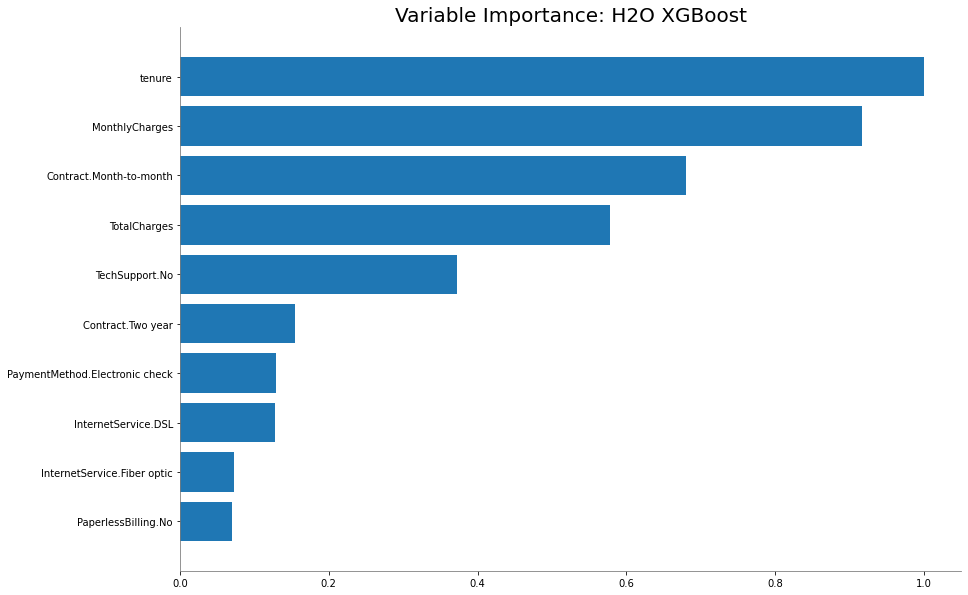

<Figure size 432x288 with 0 Axes>

In [26]:
out.varimp_plot()

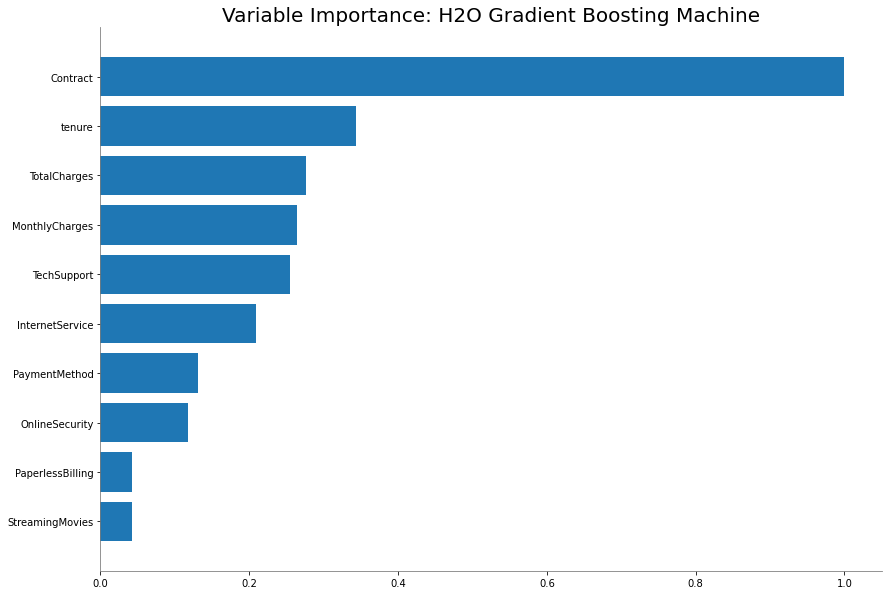

<Figure size 432x288 with 0 Axes>

In [27]:
out_gbm.varimp_plot()

In [ ]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

In [ ]:
aml.leader.download_mojo(path = "./")